# Isolation Tree vs. K-Means Isolation Tree

### Dependencies

In [4]:
%pip install scikit-learn
%pip install matplotlib
%pip install numpy
%pip install pyod

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\razva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\razva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\razva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\razva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from pyod.utils.data import generate_data
from sklearn.cluster import KMeans
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [68]:
import warnings
warnings.filterwarnings('default')

## Isolation Tree

### Isolation Tree Node

In [4]:
class IsolationTreeNode:
    def __init__(self, depth, feature_limits):
        self.depth = depth
        self.feature_limits = feature_limits

        self.idx_feature = None
        self.split_threshold = None

        self.children = []
        self.data = None


    def partition_space(self, Xs, MAX_DEPTH):
        if self.depth == MAX_DEPTH or Xs.shape[0] <= 1 or np.all(Xs == Xs[0]):
            self.data = Xs
            return

        self.idx_feature = np.random.randint(Xs.shape[1])
        self.split_threshold = np.random.uniform(
            self.feature_limits[self.idx_feature][0],
            self.feature_limits[self.idx_feature][1]
        )

        Xs_lower = Xs[Xs[:, self.idx_feature] < self.split_threshold]
        Xs_upper = Xs[Xs[:, self.idx_feature] >= self.split_threshold]

        feature_limits_lower = deepcopy(self.feature_limits)
        feature_limits_lower[self.idx_feature][1] = self.split_threshold
        feature_limits_upper = deepcopy(self.feature_limits)
        feature_limits_upper[self.idx_feature][0] = self.split_threshold

        child_lower = IsolationTreeNode(
            depth=self.depth + 1,
            feature_limits=feature_limits_lower
        )
        child_upper = IsolationTreeNode(
            depth=self.depth + 1,
            feature_limits=feature_limits_upper
        )
        
        self.children = [child_lower, child_upper]
        self.children[0].partition_space(Xs_lower, MAX_DEPTH)
        self.children[1].partition_space(Xs_upper, MAX_DEPTH)


    def get_path_length(self, X):
        if self.data is not None:
            if self.data.shape[0] <= 1:
                return 0
            else:
                HARMONIC_NUMBER = np.log(self.data.shape[0] - 1) + 0.5772156649
                return 2.0 * (HARMONIC_NUMBER - (self.data.shape[0] - 1) / self.data.shape[0])
        
        if X[self.idx_feature] < self.split_threshold:
            return 1 + self.children[0].get_path_length(X)
        else:
            return 1 + self.children[1].get_path_length(X)
    

    def plot_partition_space_2D(self):
        if self.data is not None:
            plt.scatter(self.data[:, 0], self.data[:, 1], c='lightgray', s=5)
            return

        if self.idx_feature is not None and self.split_threshold is not None:
            if self.idx_feature == 0:
                plt.plot([self.split_threshold, self.split_threshold],
                         [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')
            else:
                plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                         [self.split_threshold, self.split_threshold], c='gray')
                
        for child in self.children:
            child.plot_partition_space_2D()

### Isolation Tree

In [5]:
class IsolationTree:
    def __init__(self):
        self.feature_limits = None
        self.root = None

        self.expected_path_length = None
        self.contamination = None
        self.anomaly_threshold = None

        self.PADDING = 1.0
    

    def fit(self, Xs, subsample_size=256, contamination=0.1):
        self.feature_limits = []
        for i in range(Xs.shape[1]):
            self.feature_limits.append([np.min(Xs[:, i]) - self.PADDING, np.max(Xs[:, i]) + self.PADDING])

        self.root = IsolationTreeNode(
            depth=0,
            feature_limits=self.feature_limits
        )

        if subsample_size is not None and subsample_size < Xs.shape[0]:
            subsample_indices = np.random.choice(Xs.shape[0], subsample_size, replace=False)
            Xs_train = Xs[subsample_indices]
        else:
            Xs_train = Xs

        if Xs_train.shape[0] <= 1:
            self.expected_path_length = 0
        else:
            HARMONIC_NUMBER = np.log(Xs_train.shape[0] - 1) + 0.5772156649
            self.expected_path_length = 2.0 * (HARMONIC_NUMBER - (Xs_train.shape[0] - 1) / Xs_train.shape[0])

        # MAX_DEPTH = int(np.ceil(np.log2(Xs_train.shape[0])))
        MAX_DEPTH = 9
        self.root.partition_space(Xs_train, MAX_DEPTH)

        self.contamination = contamination
        if self.contamination is None:
            self.anomaly_threshold = 0.5
        else:
            Xs_train_depths = []
            for i in range(Xs_train.shape[0]):
                depth = self.root.get_path_length(Xs_train[i])
                Xs_train_depths.append(depth)
            Xs_train_depths = np.array(Xs_train_depths)

            Xs_train_anomaly_scores = 2.0 ** (-Xs_train_depths / self.expected_path_length)
            self.anomaly_threshold = np.quantile(Xs_train_anomaly_scores, 1.0 - self.contamination)


    def scores(self, Xs):
        scores = []
        for i in range(Xs.shape[0]):
            depth = self.root.get_path_length(Xs[i])
            score = 2.0 ** (-depth / self.expected_path_length)
            scores.append(score)
            
        scores = np.array(scores)
        return scores
    

    def predict(self, Xs):
        scores = self.scores(Xs)
        predictions = (scores >= self.anomaly_threshold).astype(int)
        return predictions
    

    def get_path_lengths(self, Xs):
        path_lengths = []
        for i in range(Xs.shape[0]):
            path_length = self.root.get_path_length(Xs[i])
            path_lengths.append(path_length)

        path_lengths = np.array(path_lengths)
        return path_lengths


    def plot_partition_space_2D(self):
        plt.title(f'Space Partition Isolation Tree')
        plt.xlabel('X')
        plt.ylabel('Y')

        plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                 [self.feature_limits[1][0], self.feature_limits[1][0]], c='gray')
        plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                 [self.feature_limits[1][1], self.feature_limits[1][1]], c='gray')
        plt.plot([self.feature_limits[0][0], self.feature_limits[0][0]],
                 [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')
        plt.plot([self.feature_limits[0][1], self.feature_limits[0][1]],
                 [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')

        self.root.plot_partition_space_2D()
        plt.show()

### Isolation Forest

In [6]:
class IsolationForest:
    def __init__(self, ensemble_size=100):
        self.ensemble_size = ensemble_size

        self.expected_path_length = None
        self.contamination = None
        self.anomaly_threshold = None

        self.trees = []
    

    def fit(self, Xs, subsample_size=256, contamination=0.1):
        self.trees = []
        for _ in range(self.ensemble_size):
            isolation_tree = IsolationTree()
            isolation_tree.fit(Xs, subsample_size=subsample_size)
            self.trees.append(isolation_tree)

        if subsample_size is not None and subsample_size < Xs.shape[0]:
            train_size = subsample_size
        else:
            train_size = Xs.shape[0]

        if train_size <= 1:
            self.expected_path_length = 0
        else:
            HARMONIC_NUMBER = np.log(train_size - 1) + 0.5772156649
            self.expected_path_length = 2.0 * (HARMONIC_NUMBER - (train_size - 1) / train_size)

        self.contamination = contamination
        if self.contamination is None:
            self.anomaly_threshold = 0.5
        else:
            Xs_train_mean_depths = []
            for i in range(Xs.shape[0]):
                mean_depth = np.mean([tree.root.get_path_length(Xs[i]) for tree in self.trees])
                Xs_train_mean_depths.append(mean_depth)
            Xs_train_mean_depths = np.array(Xs_train_mean_depths)

            Xs_train_anomaly_scores = 2.0 ** (-Xs_train_mean_depths / self.expected_path_length)
            self.anomaly_threshold = np.quantile(Xs_train_anomaly_scores, 1.0 - self.contamination)


    def scores(self, Xs):
        scores = []
        for i in range(Xs.shape[0]):
            mean_depth = np.mean([tree.root.get_path_length(Xs[i]) for tree in self.trees])
            score = 2.0 ** (-mean_depth / self.expected_path_length)
            scores.append(score)
            
        scores = np.array(scores)
        return scores
    

    def predict(self, Xs):
        scores = self.scores(Xs)
        predictions = (scores >= self.anomaly_threshold).astype(int)
        return predictions

## K-Means Isolation Tree

### Elbow Rule

In [7]:
def find_optimal_kmeans(Xs):
    initial_Ks = [2, 3, 5, 7]
    Ks = [k for k in initial_Ks if k <= Xs.shape[0]]

    kmeans_list = []
    inertias = []

    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=23)
        kmeans.fit(Xs)

        kmeans_list.append(kmeans)
        inertias.append(kmeans.inertia_)

    if len(Ks) <= 2:
        return Ks[0], kmeans_list[0]

    start_point = np.array([Ks[0], inertias[0]])
    end_point = np.array([Ks[-1], inertias[-1]])
    distances = []

    for i in range(len(Ks)):
        current_point = np.array([Ks[i], inertias[i]])

        area = np.abs(np.cross(end_point - start_point, current_point - start_point))
        base_length = np.linalg.norm(end_point - start_point)

        distance = area / base_length
        distances.append(distance)

    optimal_k = Ks[np.argmax(distances)]
    optimal_kmeans = kmeans_list[np.argmax(distances)]
    return optimal_k, optimal_kmeans

In [8]:
def plot_elbow_rule(Xs):
    initial_Ks = [2, 3, 5, 7]
    Ks = [k for k in initial_Ks if k <= Xs.shape[0]]

    inertias = []

    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=23)
        kmeans.fit(Xs)

        inertias.append(kmeans.inertia_)

    optimal_k, _ = find_optimal_kmeans(Xs)

    plt.plot(Ks, inertias)
    plt.plot([Ks[0], Ks[-1]], [inertias[0], inertias[-1]])
    plt.scatter(optimal_k, inertias[Ks.index(optimal_k)])
    plt.title('Elbow Rule for Optimal K')
    plt.xlabel('Number of Clusters K')
    plt.ylabel('Inertia')
    plt.show()

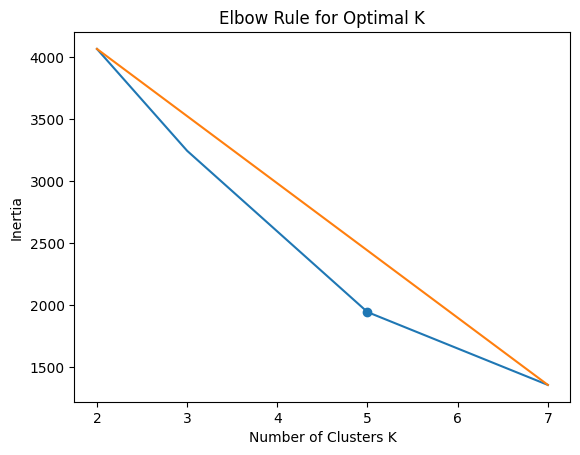

Elbow Rule Optimal K: 5


In [9]:
Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=100, n_features=2, contamination=0.1, random_state=23)

plot_elbow_rule(Xs_train)

print(f'Elbow Rule Optimal K: {find_optimal_kmeans(Xs_train)[0]}')

### K-Means Isolation Tree Node

In [ ]:
class KMeansIsolationTreeNode:
    def __init__(self, depth, feature_limits):
        self.depth = depth
        self.feature_limits = feature_limits

        self.idx_feature = None
        self.split_thresholds = []
        self.cluster_centers = []
        self.cluster_radii = []

        self.children = []
        self.data = None


    def partition_space(self, Xs, MAX_DEPTH):
        if self.depth == MAX_DEPTH or Xs.shape[0] <= 1 or np.all(Xs == Xs[0]):
            self.data = Xs
            return

        self.idx_feature = np.random.randint(Xs.shape[1])
        Xs_projected = Xs[:, self.idx_feature]

        _, kmeans = find_optimal_kmeans(Xs_projected.reshape(-1, 1))

        self.cluster_centers = sorted(kmeans.cluster_centers_.flatten().tolist())
        self.split_thresholds = []
        for idx in range(1, len(self.cluster_centers)):
            split_threshold = (self.cluster_centers[idx - 1] + self.cluster_centers[idx]) / 2.0
            self.split_thresholds.append(split_threshold)
        self.cluster_radii = [0.0 for _ in range(len(self.cluster_centers))]
        for X_projected in Xs_projected:
            cluster_distances = [np.abs(X_projected - cluster_center) for cluster_center in self.cluster_centers]
            closest_cluster_idx = np.argmin(cluster_distances)
            if cluster_distances[closest_cluster_idx] > self.cluster_radii[closest_cluster_idx]:
                self.cluster_radii[closest_cluster_idx] = cluster_distances[closest_cluster_idx]

        self.children = []
        for idx in range(len(self.split_thresholds)):
            if idx == 0:
                threshold_lower = self.feature_limits[self.idx_feature][0]
            else:
                threshold_lower = self.split_thresholds[idx - 1]
            threshold_upper = self.split_thresholds[idx]

            Xs_between = Xs[
                (threshold_lower <= Xs[:, self.idx_feature]) &
                (Xs[:, self.idx_feature] < threshold_upper)
            ]

            feature_limits_between = deepcopy(self.feature_limits)
            feature_limits_between[self.idx_feature][0] = threshold_lower
            feature_limits_between[self.idx_feature][1] = threshold_upper

            child = KMeansIsolationTreeNode(
                depth=self.depth + 1,
                feature_limits=feature_limits_between
            )
            self.children.append(child)
            self.children[-1].partition_space(Xs_between, MAX_DEPTH)

        threshold_lower = self.split_thresholds[-1]
        threshold_upper = self.feature_limits[self.idx_feature][1]

        Xs_between = Xs[
            (threshold_lower <= Xs[:, self.idx_feature]) &
            (Xs[:, self.idx_feature] <= threshold_upper)
        ]

        feature_limits_between = deepcopy(self.feature_limits)
        feature_limits_between[self.idx_feature][0] = threshold_lower
        feature_limits_between[self.idx_feature][1] = threshold_upper

        child = KMeansIsolationTreeNode(
            depth=self.depth + 1,
            feature_limits=feature_limits_between
        )
        self.children.append(child)
        self.children[-1].partition_space(Xs_between, MAX_DEPTH)


    def get_path_length(self, X):
        if self.data is not None:
            return 0
        
        for idx in range(len(self.split_thresholds)):
            if X[self.idx_feature] < self.split_thresholds[idx]:
                return 1 + self.children[idx].get_path_length(X)
        return 1 + self.children[-1].get_path_length(X)
    

    def get_normality_score(self, X):
        if self.data is not None:
            return 0.0

        X_projected = X[self.idx_feature]

        cluster_distances = [np.abs(X_projected - cluster_center) for cluster_center in self.cluster_centers]
        closest_cluster_idx = np.argmin(cluster_distances)
        cluster_radius = self.cluster_radii[closest_cluster_idx]

        if cluster_radius == 0.0:
            normality_score = 1.0
        else:
            normality_score = 1.0 - (cluster_distances[closest_cluster_idx] / cluster_radius)
        normality_score = np.maximum(0.0, normality_score) # to keep scores in [0.0, 1.0] for unseen data (which might be outside cluster radius)
        
        for idx in range(len(self.split_thresholds)):
            if X_projected < self.split_thresholds[idx]:
                return normality_score + self.children[idx].get_normality_score(X)
        return normality_score + self.children[-1].get_normality_score(X)
    

    def plot_partition_space_2D(self):
        if self.data is not None:
            plt.scatter(self.data[:, 0], self.data[:, 1], c='lightgray', s=5)
            return

        if self.idx_feature is not None:
            if self.idx_feature == 0:
                for split_threshold in self.split_thresholds:
                    plt.plot([split_threshold, split_threshold],
                            [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')
            else:
                for split_threshold in self.split_thresholds:
                    plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                            [split_threshold, split_threshold], c='gray')
                
        for child in self.children:
            child.plot_partition_space_2D()

### K-Means Isolation Tree

In [11]:
class KMeansIsolationTree:
    def __init__(self):
        self.feature_limits = None
        self.root = None

        self.contamination = None
        self.anomaly_threshold = None

        self.PADDING = 1.0
    

    def fit(self, Xs, subsample_size=256, contamination=0.1):
        self.feature_limits = []
        for i in range(Xs.shape[1]):
            self.feature_limits.append([np.min(Xs[:, i]) - self.PADDING, np.max(Xs[:, i]) + self.PADDING])

        self.root = KMeansIsolationTreeNode(
            depth=0,
            feature_limits=self.feature_limits
        )

        if subsample_size is not None and subsample_size < Xs.shape[0]:
            subsample_indices = np.random.choice(Xs.shape[0], subsample_size, replace=False)
            Xs_train = Xs[subsample_indices]
        else:
            Xs_train = Xs

        # MAX_DEPTH = int(np.ceil(np.log2(Xs_train.shape[0])))
        MAX_DEPTH = 9
        self.root.partition_space(Xs_train, MAX_DEPTH)

        self.contamination = contamination
        if self.contamination is None:
            self.anomaly_threshold = 0.5
        else:
            Xs_train_normality_scores = []
            for i in range(Xs_train.shape[0]):
                normality_score = self.root.get_normality_score(Xs_train[i])
                Xs_train_normality_scores.append(normality_score)
            Xs_train_normality_scores = np.array(Xs_train_normality_scores)

            Xs_train_anomaly_scores = 1.0 - Xs_train_normality_scores
            self.anomaly_threshold = np.quantile(Xs_train_anomaly_scores, 1.0 - self.contamination)


    def normality_scores(self, Xs):
        normality_scores = []
        for i in range(Xs.shape[0]):
            normality_score = self.root.get_normality_score(Xs[i])
            normality_scores.append(normality_score)
            
        normality_scores = np.array(normality_scores)
        return normality_scores
    

    def scores(self, Xs):
        normality_scores = self.normality_scores(Xs)
        anomaly_scores = 1.0 - normality_scores
        return anomaly_scores
    

    def predict(self, Xs):
        anomaly_scores = self.scores(Xs)
        predictions = (anomaly_scores >= self.anomaly_threshold).astype(int)
        return predictions
    

    def get_path_lengths(self, Xs):
        path_lengths = []
        for i in range(Xs.shape[0]):
            path_length = self.root.get_path_length(Xs[i])
            path_lengths.append(path_length)

        path_lengths = np.array(path_lengths)
        return path_lengths


    def plot_partition_space_2D(self):
        plt.title(f'Space Partition KMeans Isolation Tree')
        plt.xlabel('X')
        plt.ylabel('Y')

        plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                 [self.feature_limits[1][0], self.feature_limits[1][0]], c='gray')
        plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                 [self.feature_limits[1][1], self.feature_limits[1][1]], c='gray')
        plt.plot([self.feature_limits[0][0], self.feature_limits[0][0]],
                 [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')
        plt.plot([self.feature_limits[0][1], self.feature_limits[0][1]],
                 [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')

        self.root.plot_partition_space_2D()
        plt.show()        

### K-Means Isolation Forest

In [12]:
class KMeansIsolationForest:
    def __init__(self, ensemble_size=100):
        self.ensemble_size = ensemble_size

        self.contamination = None
        self.anomaly_threshold = None

        self.trees = []
    

    def fit(self, Xs, subsample_size=256, contamination=0.1):
        self.trees = []
        for _ in range(self.ensemble_size):
            kmeans_isolation_tree = KMeansIsolationTree()
            kmeans_isolation_tree.fit(Xs, subsample_size=subsample_size)
            self.trees.append(kmeans_isolation_tree)

        if subsample_size is not None and subsample_size < Xs.shape[0]:
            train_size = subsample_size
        else:
            train_size = Xs.shape[0]

        self.contamination = contamination
        if self.contamination is None:
            self.anomaly_threshold = 0.5
        else:
            Xs_train_mean_normality_scores = []
            for i in range(Xs.shape[0]):
                mean_normality_score = np.mean([tree.root.get_normality_score(Xs[i]) for tree in self.trees])
                Xs_train_mean_normality_scores.append(mean_normality_score)
            Xs_train_mean_normality_scores = np.array(Xs_train_mean_normality_scores)

            Xs_train_anomaly_scores = 1.0 - Xs_train_mean_normality_scores
            self.anomaly_threshold = np.quantile(Xs_train_anomaly_scores, 1.0 - self.contamination)


    def scores(self, Xs):
        anomaly_scores = []
        for i in range(Xs.shape[0]):
            mean_normality_score = np.mean([tree.root.get_normality_score(Xs[i]) for tree in self.trees])
            anomaly_score = 1.0 - mean_normality_score
            anomaly_scores.append(anomaly_score)
            
        anomaly_scores = np.array(anomaly_scores)
        return anomaly_scores
    

    def predict(self, Xs):
        anomaly_scores = self.scores(Xs)
        predictions = (anomaly_scores >= self.anomaly_threshold).astype(int)
        return predictions

# Tests

## Synthetic Dataset Tests

In [21]:
def synthetic_dataset_demo_0(model, is_ensemble=False):
    CONTAMINATION = 0.1
    SUBSAMPLE_SIZE = 128

    Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=1000, n_features=2, contamination=CONTAMINATION, random_state=23)

    model.fit(Xs_train, subsample_size=SUBSAMPLE_SIZE, contamination=CONTAMINATION)
    if not is_ensemble:
        model.plot_partition_space_2D()

    train_predictions = model.predict(Xs_train)
    validation_predictions = model.predict(Xs_test)
    train_scores = model.scores(Xs_train)
    validation_scores = model.scores(Xs_test)
    print('Anomaly Threshold: ', model.anomaly_threshold)

    print('Train Accuracy: ', np.mean(train_predictions == Ys_train))
    print('Validation Accuracy: ', np.mean(validation_predictions == Ys_test))
    print('Train Balanced Accuracy: ', balanced_accuracy_score(Ys_train, train_predictions))
    print('Validation Balanced Accuracy: ', balanced_accuracy_score(Ys_test, validation_predictions))
    print('Train F1 Score: ', f1_score(Ys_train, train_predictions))
    print('Validation F1 Score: ', f1_score(Ys_test, validation_predictions))
    area_under_curve_train = average_precision_score(Ys_train, train_scores)
    area_under_curve_validation = average_precision_score(Ys_test, validation_scores)
    precision_train, recall_train, _ = precision_recall_curve(Ys_train, train_scores)
    precision_validation, recall_validation, _ = precision_recall_curve(Ys_test, validation_scores)

    _, axes = plt.subplots(2, 3, figsize=(12, 5))
    axes = axes.flatten()
    axes[0].set_title('Train Data True Labels')
    axes[0].scatter(Xs_train[:, 0], Xs_train[:, 1], c=Ys_train, s=5)
    axes[1].set_title('Train Data Predicted Labels')
    axes[1].scatter(Xs_train[:, 0], Xs_train[:, 1], c=train_predictions, s=5)

    axes[2].set_title(f'Precision-Recall Curve Train Data (AUC={area_under_curve_train})')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].plot(recall_train, precision_train, c='orange')

    axes[3].set_title('Validation Data True Labels')
    axes[3].scatter(Xs_test[:, 0], Xs_test[:, 1], c=Ys_test, s=5)
    axes[4].set_title('Validation Data Predicted Labels')
    axes[4].scatter(Xs_test[:, 0], Xs_test[:, 1], c=validation_predictions, s=5)

    axes[5].set_title(f'Precision-Recall Curve Val Data (AUC={area_under_curve_validation})')
    axes[5].set_xlabel('Recall')
    axes[5].set_ylabel('Precision')
    axes[5].plot(recall_validation, precision_validation, c='orange')

    plt.tight_layout()
    plt.show()

In [22]:
def generate_synthetic_dataset(num_train, num_test, contamination, seed):
    np.random.seed(seed)

    rectangles = [
        [[-30.0, -20.0], [-30.0, -25.0]],
        [[-5.0, 5.0], [-30.0, -25.0]],
        [[20.0, 30.0], [-30.0, -25.0]],

        [[-30.0, -20.0], [-2.5, 2.5]],
        [[-5.0, 5.0], [-2.5, 2.5]],
        [[20.0, 30.0], [-2.5, 2.5]],

        [[-30.0, -20.0], [25.0, 30.0]],
        [[-5.0, 5.0], [25.0, 30.0]],
        [[20.0, 30.0], [25.0, 30.0]], 
    ]

    num_normal = int((1.0 - contamination) * (num_train + num_test))
    num_anomalies = (num_train + num_test) - num_normal

    Xs_normal = None
    Ys_normal = np.zeros(num_normal, dtype=int)
    for rectangle in rectangles:
        left = rectangle[0][0]
        right = rectangle[0][1]
        bottom = rectangle[1][0]
        top = rectangle[1][1]

        num_samples_per_rectangle = num_normal // len(rectangles)
        if rectangle == rectangles[-1]:
            num_samples_per_rectangle += num_normal % len(rectangles)

        Xs_rectangle = np.random.uniform(
            low=[left, bottom],
            high=[right, top],
            size=(num_samples_per_rectangle, 2)
        )

        if rectangle == rectangles[0]:
            Xs_normal = Xs_rectangle
        else:
            Xs_normal = np.vstack((Xs_normal, Xs_rectangle))

    Xs_anomalies = np.random.uniform(
        low=[-50.0, -50.0],
        high=[50.0, 50.0],
        size=(num_anomalies, 2)
    )
    Ys_anomalies = np.ones(num_anomalies, dtype=int)

    Xs_all = np.vstack((Xs_normal, Xs_anomalies))
    Ys_all = np.hstack((Ys_normal, Ys_anomalies))

    Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(Xs_all, Ys_all, test_size=num_test, random_state=seed)
    return Xs_train, Xs_test, Ys_train, Ys_test


def synthetic_dataset_demo_1(model, is_ensemble=False):
    CONTAMINATION = 0.1
    SUBSAMPLE_SIZE = 128

    Xs_train, Xs_test, Ys_train, Ys_test = generate_synthetic_dataset(num_train=3000, num_test=1000, contamination=CONTAMINATION, seed=23)

    model.fit(Xs_train, subsample_size=SUBSAMPLE_SIZE, contamination=CONTAMINATION)
    if not is_ensemble:
        model.plot_partition_space_2D()

    train_predictions = model.predict(Xs_train)
    validation_predictions = model.predict(Xs_test)
    train_scores = model.scores(Xs_train)
    validation_scores = model.scores(Xs_test)
    print('Anomaly Threshold: ', model.anomaly_threshold)

    print('Train Accuracy: ', np.mean(train_predictions == Ys_train))
    print('Validation Accuracy: ', np.mean(validation_predictions == Ys_test))
    print('Train Balanced Accuracy: ', balanced_accuracy_score(Ys_train, train_predictions))
    print('Validation Balanced Accuracy: ', balanced_accuracy_score(Ys_test, validation_predictions))
    print('Train F1 Score: ', f1_score(Ys_train, train_predictions))
    print('Validation F1 Score: ', f1_score(Ys_test, validation_predictions))
    area_under_curve_train = average_precision_score(Ys_train, train_scores)
    area_under_curve_validation = average_precision_score(Ys_test, validation_scores)
    precision_train, recall_train, _ = precision_recall_curve(Ys_train, train_scores)
    precision_validation, recall_validation, _ = precision_recall_curve(Ys_test, validation_scores)

    _, axes = plt.subplots(2, 3, figsize=(12, 5))
    axes = axes.flatten()
    axes[0].set_title('Train Data True Labels')
    axes[0].scatter(Xs_train[:, 0], Xs_train[:, 1], c=Ys_train, s=5)
    axes[1].set_title('Train Data Predicted Labels')
    axes[1].scatter(Xs_train[:, 0], Xs_train[:, 1], c=train_predictions, s=5)

    axes[2].set_title(f'Precision-Recall Curve Train Data (AUC={area_under_curve_train})')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].plot(recall_train, precision_train, c='orange')

    axes[3].set_title('Validation Data True Labels')
    axes[3].scatter(Xs_test[:, 0], Xs_test[:, 1], c=Ys_test, s=5)
    axes[4].set_title('Validation Data Predicted Labels')
    axes[4].scatter(Xs_test[:, 0], Xs_test[:, 1], c=validation_predictions, s=5)

    axes[5].set_title(f'Precision-Recall Curve Val Data (AUC={area_under_curve_validation})')
    axes[5].set_xlabel('Recall')
    axes[5].set_ylabel('Precision')
    axes[5].plot(recall_validation, precision_validation, c='orange')

    plt.tight_layout()
    plt.show()

### Isolation Tree Synthetic Dataset Tests

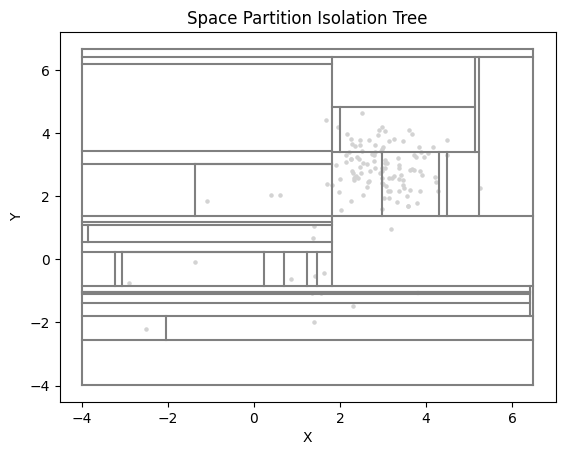

Anomaly Threshold:  0.488552466640037
Train Accuracy:  0.9303333333333333
Validation Accuracy:  0.927
Train Balanced Accuracy:  0.8798148148148148
Validation Balanced Accuracy:  0.8616666666666667
Train F1 Score:  0.7010014306151645
Validation F1 Score:  0.6812227074235808


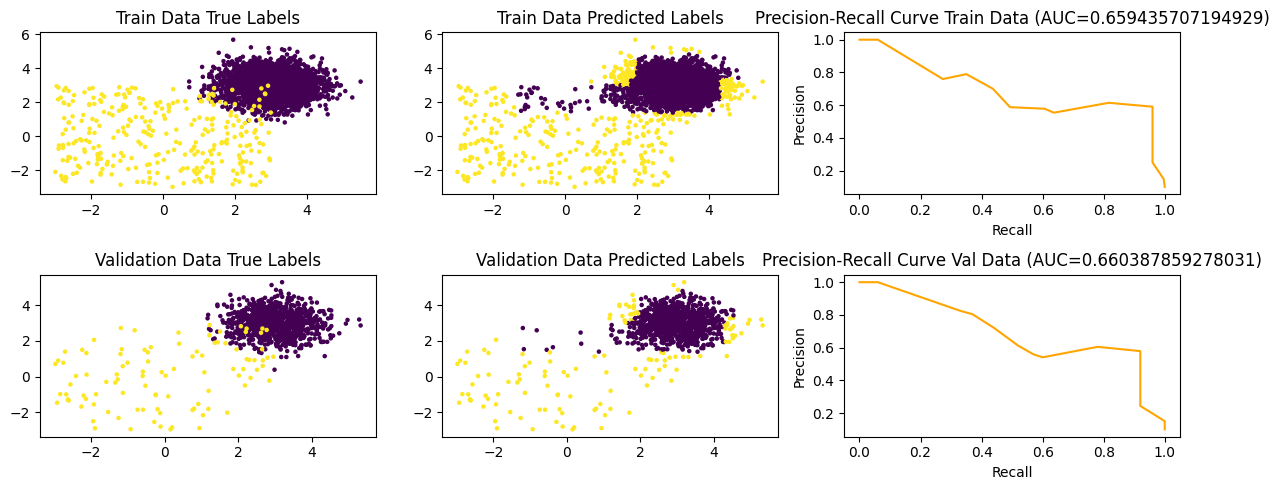

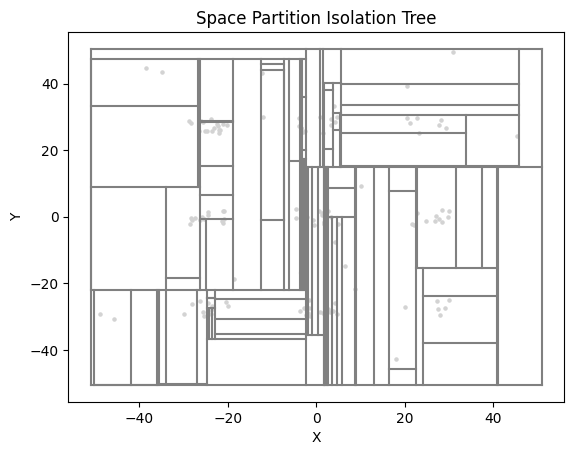

Anomaly Threshold:  0.5065658534361867
Train Accuracy:  0.8546666666666667
Validation Accuracy:  0.863
Train Balanced Accuracy:  0.7069286883233283
Validation Balanced Accuracy:  0.7073478678379628
Train F1 Score:  0.42328042328042326
Validation F1 Score:  0.41201716738197425


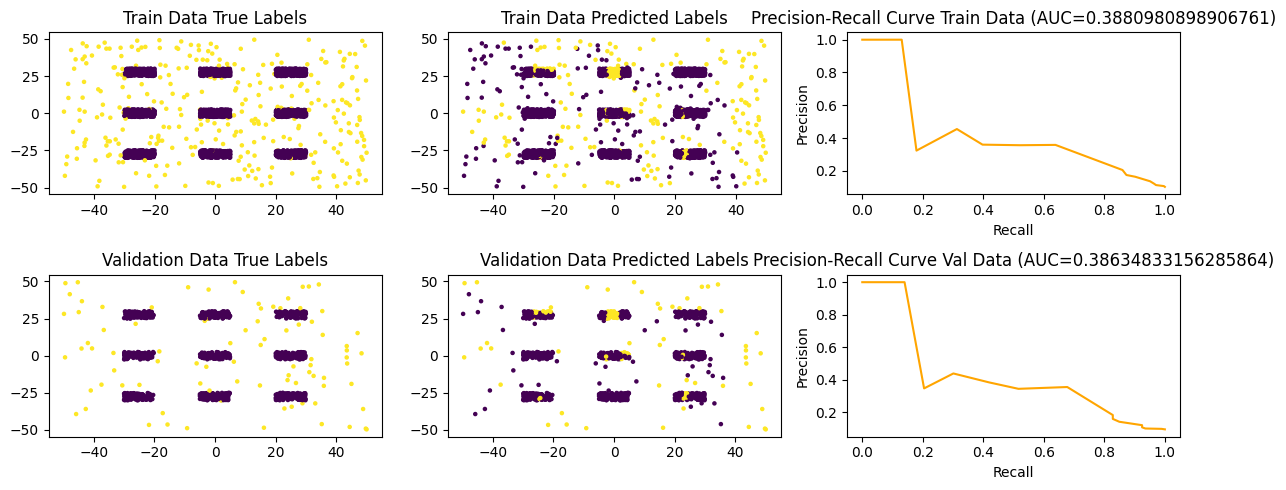

In [23]:
synthetic_dataset_demo_0(IsolationTree(), is_ensemble=False)
synthetic_dataset_demo_1(IsolationTree(), is_ensemble=False)

### K-Means Isolation Tree Synthetic Dataset Tests

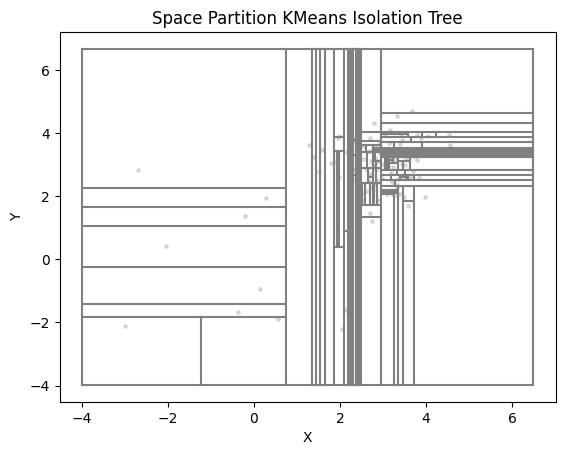

Anomaly Threshold:  -0.8514416945447244
Train Accuracy:  0.8633333333333333
Validation Accuracy:  0.859
Train Balanced Accuracy:  0.7581481481481482
Validation Balanced Accuracy:  0.7572222222222222
Train F1 Score:  0.47837150127226463
Validation F1 Score:  0.47191011235955055


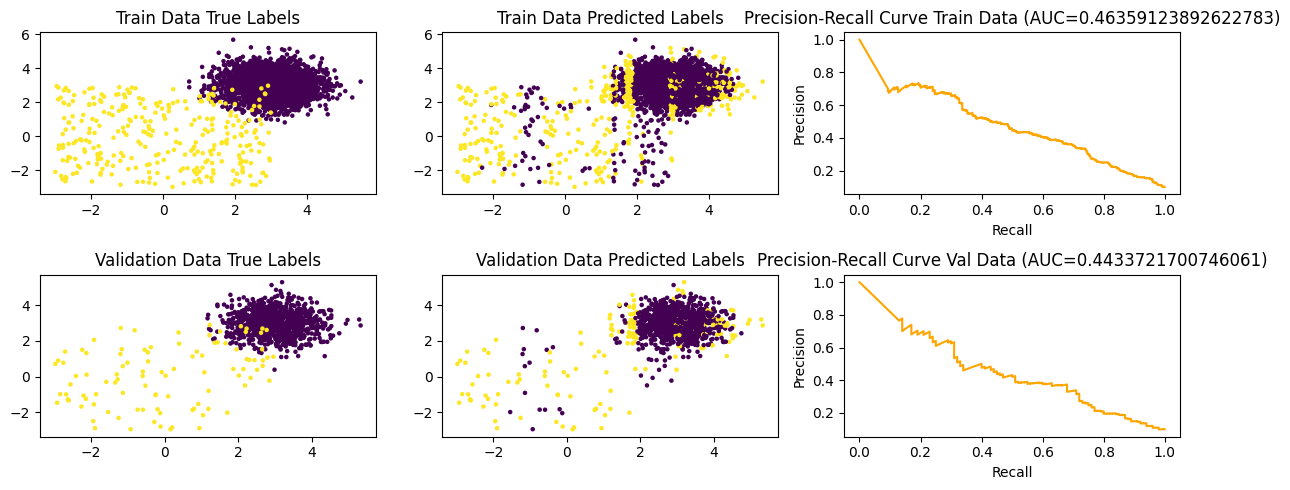

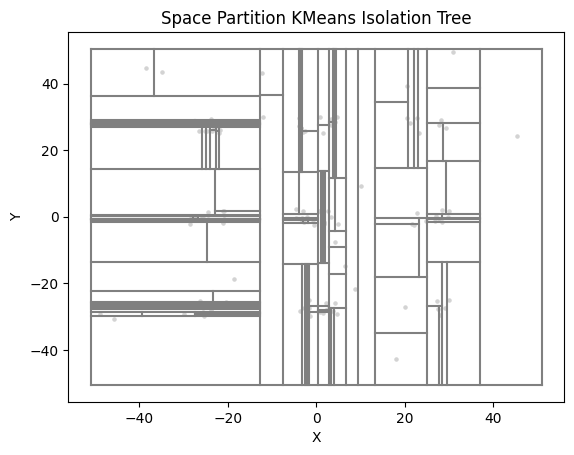

Anomaly Threshold:  -0.9340672405221719
Train Accuracy:  0.927
Validation Accuracy:  0.924
Train Balanced Accuracy:  0.8121532359803616
Validation Balanced Accuracy:  0.7699256677454921
Train F1 Score:  0.6518282988871225
Validation F1 Score:  0.5869565217391305


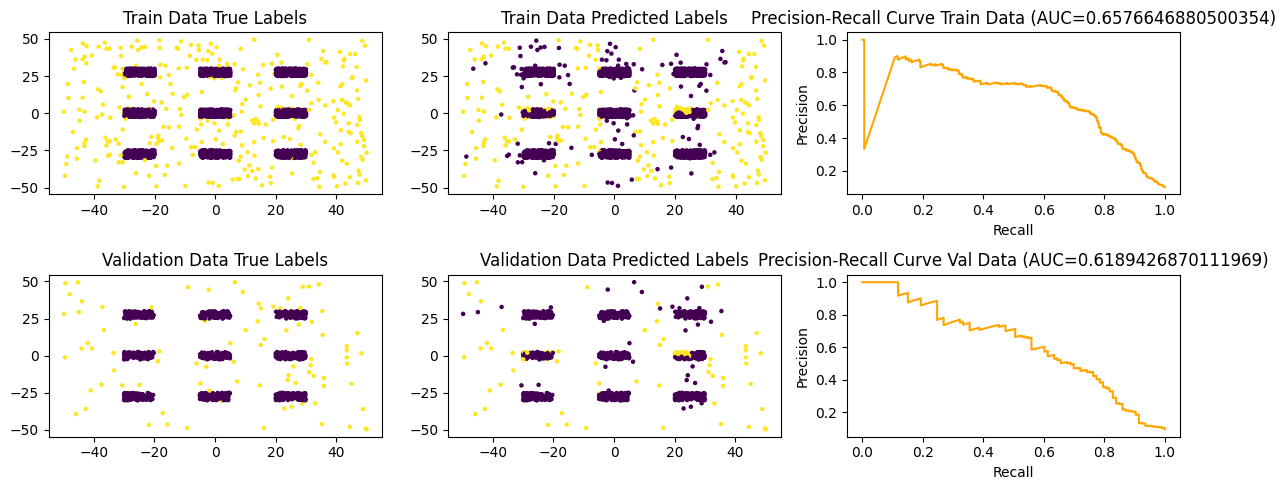

In [24]:
synthetic_dataset_demo_0(KMeansIsolationTree(), is_ensemble=False)
synthetic_dataset_demo_1(KMeansIsolationTree(), is_ensemble=False)

### Isolation Forest Synthetic Dataset Tests

Anomaly Threshold:  0.45827869445998837
Train Accuracy:  0.9793333333333333
Validation Accuracy:  0.969
Train Balanced Accuracy:  0.9425925925925925
Validation Balanced Accuracy:  0.8894444444444445
Train F1 Score:  0.8966666666666666
Validation F1 Score:  0.8359788359788359


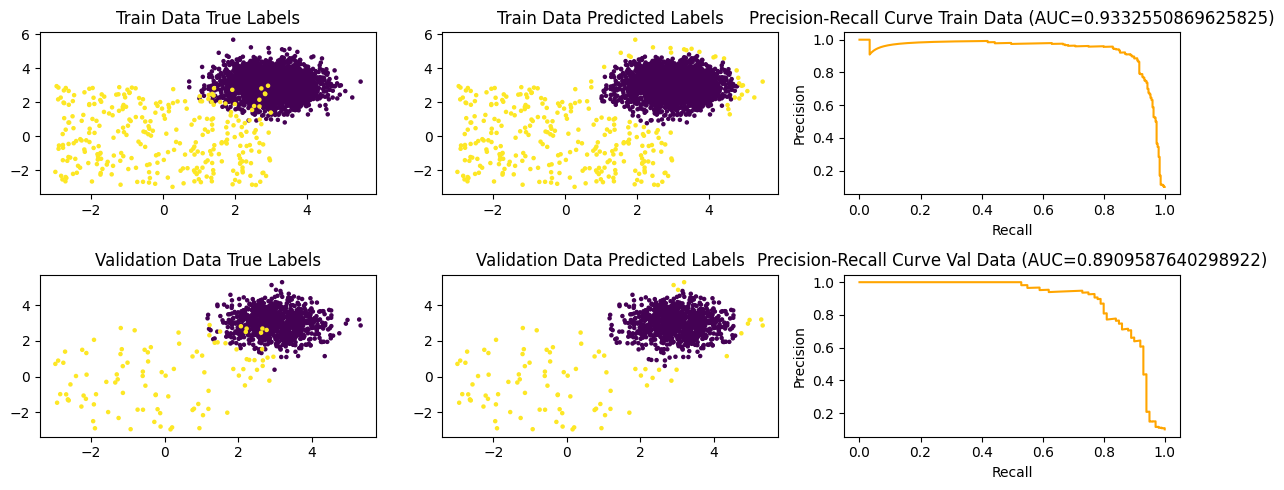

Anomaly Threshold:  0.42208020543518676
Train Accuracy:  0.9863333333333333
Validation Accuracy:  0.979
Train Balanced Accuracy:  0.9577557208881513
Validation Balanced Accuracy:  0.9449976882313191
Train F1 Score:  0.9324546952224053
Validation F1 Score:  0.8888888888888888


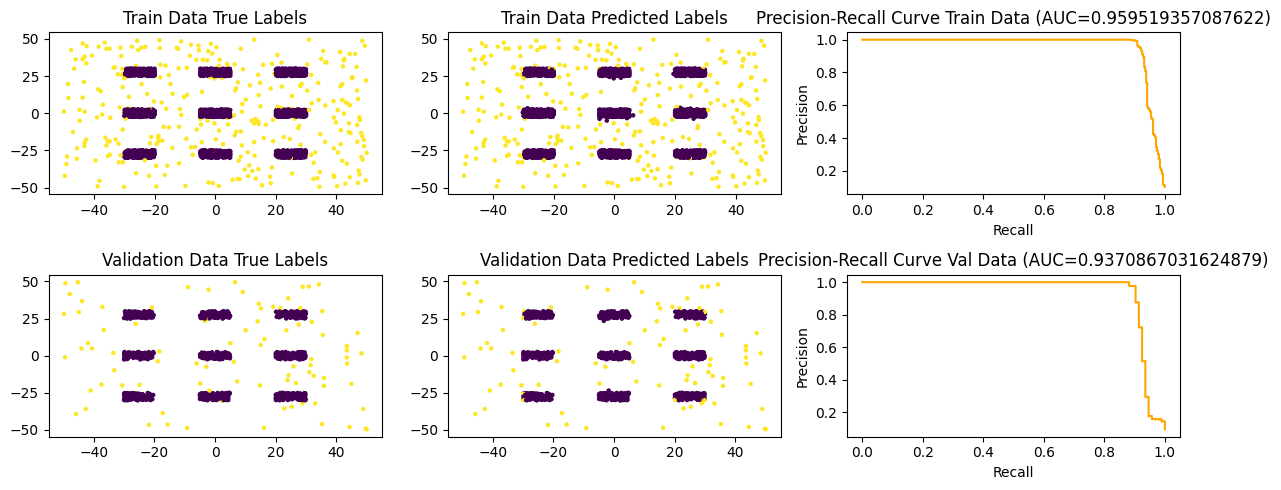

In [25]:
synthetic_dataset_demo_0(IsolationForest(ensemble_size=100), is_ensemble=True)
synthetic_dataset_demo_1(IsolationForest(ensemble_size=100), is_ensemble=True)

### K-Means Isolation Forest Synthetic Dataset Tests

Anomaly Threshold:  -1.0015423643377055
Train Accuracy:  0.9686666666666667
Validation Accuracy:  0.968
Train Balanced Accuracy:  0.912962962962963
Validation Balanced Accuracy:  0.8933333333333333
Train F1 Score:  0.8433333333333334
Validation F1 Score:  0.8333333333333334


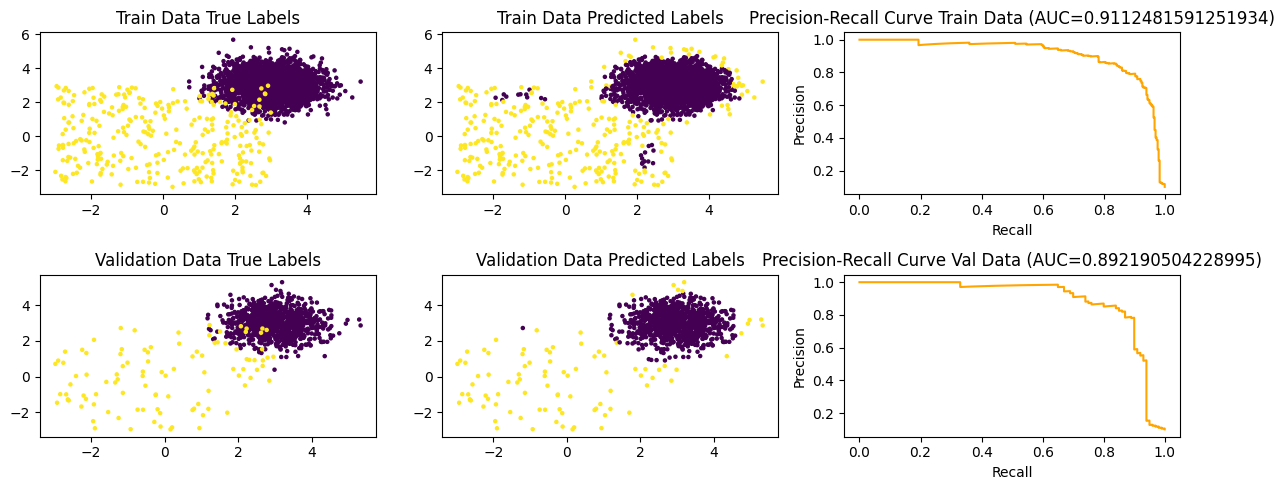

Anomaly Threshold:  -1.3571625897884303
Train Accuracy:  0.981
Validation Accuracy:  0.977
Train Balanced Accuracy:  0.9432410725841275
Validation Balanced Accuracy:  0.9052945430403907
Train F1 Score:  0.9060955518945635
Validation F1 Score:  0.8685714285714285


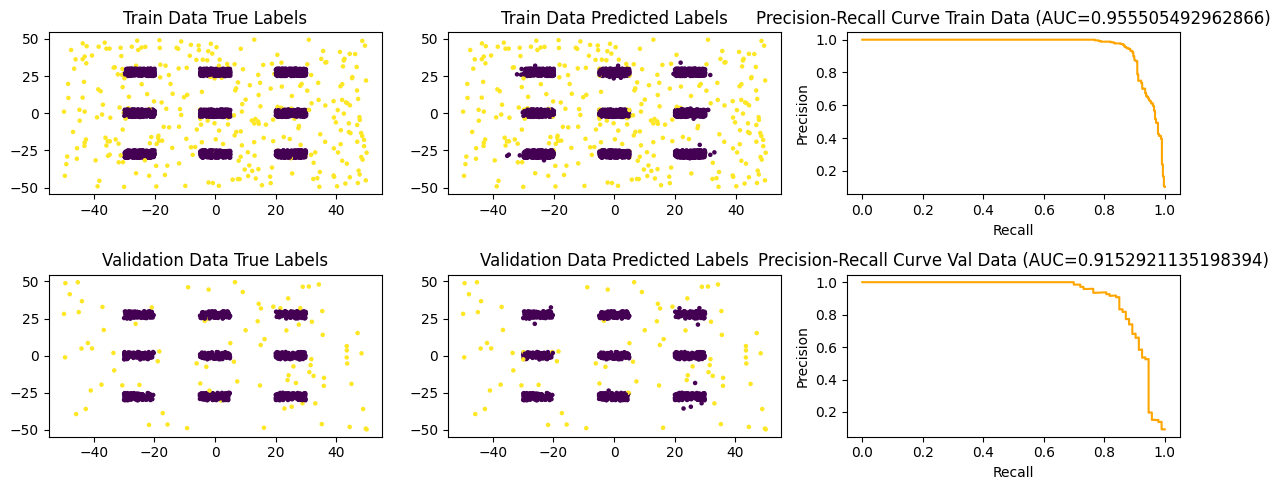

In [26]:
synthetic_dataset_demo_0(KMeansIsolationForest(ensemble_size=100), is_ensemble=True)
synthetic_dataset_demo_1(KMeansIsolationForest(ensemble_size=100), is_ensemble=True)

## Robustness Tests

### Gradually Increasing Contamination Rate

Isolation Forest Train Accuracy with contamination=0.1: 1.0
KMeans Isolation Forest Train Accuracy with contamination=0.1: 0.9986666666666667
Isolation Forest Validation Accuracy with contamination=0.1: 1.0
KMeans Isolation Forest Validation Accuracy with contamination=0.1: 0.998
Isolation Forest Train Accuracy with contamination=0.2: 1.0
KMeans Isolation Forest Train Accuracy with contamination=0.2: 0.9966666666666667
Isolation Forest Validation Accuracy with contamination=0.2: 1.0
KMeans Isolation Forest Validation Accuracy with contamination=0.2: 0.992
Isolation Forest Train Accuracy with contamination=0.30000000000000004: 0.9993333333333333
KMeans Isolation Forest Train Accuracy with contamination=0.30000000000000004: 0.98
Isolation Forest Validation Accuracy with contamination=0.30000000000000004: 0.999
KMeans Isolation Forest Validation Accuracy with contamination=0.30000000000000004: 0.982
Isolation Forest Train Accuracy with contamination=0.4: 0.998
KMeans Isolation Forest Trai

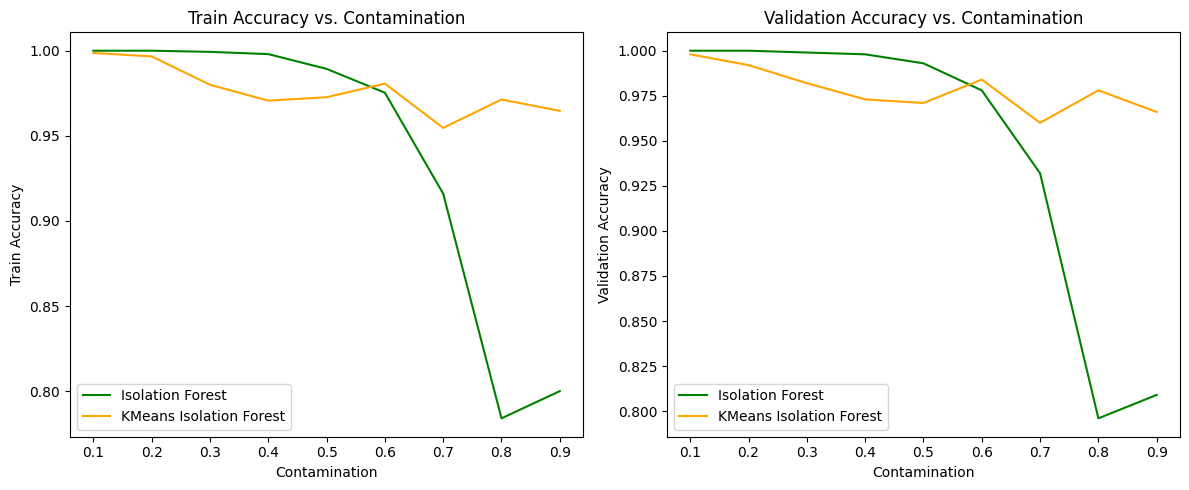

In [74]:
ENSEMBLE_SIZE = 100
SUBSAMPLE_SIZE = 128

contaminations = [0.1 * i for i in range(1, 10)]

isolation_forest_train_accuracies = []
kmeans_isolation_forest_train_accuracies = []

isolation_forest_validation_accuracies = []
kmeans_isolation_forest_validation_accuracies = []

for contamination in contaminations:
    Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=1000, n_features=10, contamination=contamination, random_state=23)

    isolation_forest = IsolationForest(ensemble_size=ENSEMBLE_SIZE)
    kmeans_isolation_forest = KMeansIsolationForest(ensemble_size=ENSEMBLE_SIZE)
    isolation_forest.fit(Xs_train, subsample_size=SUBSAMPLE_SIZE, contamination=contamination)
    kmeans_isolation_forest.fit(Xs_train, subsample_size=SUBSAMPLE_SIZE, contamination=contamination)

    isolation_forest_train_predictions = isolation_forest.predict(Xs_train)
    kmeans_isolation_forest_train_predictions = kmeans_isolation_forest.predict(Xs_train)
    isolation_forest_validation_predictions = isolation_forest.predict(Xs_test)
    kmeans_isolation_forest_validation_predictions = kmeans_isolation_forest.predict(Xs_test)

    isolation_forest_train_accuracy = np.mean(isolation_forest_train_predictions == Ys_train)
    kmeans_isolation_forest_train_accuracy = np.mean(kmeans_isolation_forest_train_predictions == Ys_train)
    isolation_forest_validation_accuracy = np.mean(isolation_forest_validation_predictions == Ys_test)
    kmeans_isolation_forest_validation_accuracy = np.mean(kmeans_isolation_forest_validation_predictions == Ys_test)

    print(f'Isolation Forest Train Accuracy with contamination={contamination}: {isolation_forest_train_accuracy}')
    print(f'KMeans Isolation Forest Train Accuracy with contamination={contamination}: {kmeans_isolation_forest_train_accuracy}')
    print(f'Isolation Forest Validation Accuracy with contamination={contamination}: {isolation_forest_validation_accuracy}')
    print(f'KMeans Isolation Forest Validation Accuracy with contamination={contamination}: {kmeans_isolation_forest_validation_accuracy}')

    isolation_forest_train_accuracies.append(isolation_forest_train_accuracy)
    kmeans_isolation_forest_train_accuracies.append(kmeans_isolation_forest_train_accuracy)
    isolation_forest_validation_accuracies.append(isolation_forest_validation_accuracy)
    kmeans_isolation_forest_validation_accuracies.append(kmeans_isolation_forest_validation_accuracy)

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
axes[0].set_title('Train Accuracy vs. Contamination')
axes[0].set_xlabel('Contamination')
axes[0].set_ylabel('Train Accuracy')
axes[0].plot(contaminations, isolation_forest_train_accuracies, label='Isolation Forest', c='green')
axes[0].plot(contaminations, kmeans_isolation_forest_train_accuracies, label='KMeans Isolation Forest', c='orange')
axes[0].legend()

axes[1].set_title('Validation Accuracy vs. Contamination')
axes[1].set_xlabel('Contamination')
axes[1].set_ylabel('Validation Accuracy')
axes[1].plot(contaminations, isolation_forest_validation_accuracies, label='Isolation Forest', c='green')
axes[1].plot(contaminations, kmeans_isolation_forest_validation_accuracies, label='KMeans Isolation Forest', c='orange')
axes[1].legend()

plt.tight_layout()
plt.show()

### Adding Gaussian Noise (and gradually increasing standard deviation)

In [81]:
CONTAMINATION = 0.1

Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=1000, n_features=10, contamination=CONTAMINATION, random_state=23)

print(f'Xs_train Min: {np.min(Xs_train)}')
print(f'Xs_train Max: {np.max(Xs_train)}')
print(f'Xs_test Min: {np.min(Xs_test)}')
print(f'Xs_test Max: {np.max(Xs_test)}')

Xs_train Min: -2.9977905434305105
Xs_train Max: 5.679782482373361
Xs_test Min: -2.9993262976782136
Xs_test Max: 5.44034097003567


Isolation Forest Train Accuracy with standard_deviation=0.25: 1.0
KMeans Isolation Forest Train Accuracy with standard_deviation=0.25: 0.9926666666666667
Isolation Forest Validation Accuracy with standard_deviation=0.25: 1.0
KMeans Isolation Forest Validation Accuracy with standard_deviation=0.25: 0.995
Isolation Forest Train Accuracy with standard_deviation=0.5: 1.0
KMeans Isolation Forest Train Accuracy with standard_deviation=0.5: 0.9926666666666667
Isolation Forest Validation Accuracy with standard_deviation=0.5: 1.0
KMeans Isolation Forest Validation Accuracy with standard_deviation=0.5: 0.99
Isolation Forest Train Accuracy with standard_deviation=1.0: 0.996
KMeans Isolation Forest Train Accuracy with standard_deviation=1.0: 0.9813333333333333
Isolation Forest Validation Accuracy with standard_deviation=1.0: 0.996
KMeans Isolation Forest Validation Accuracy with standard_deviation=1.0: 0.976
Isolation Forest Train Accuracy with standard_deviation=2.0: 0.946
KMeans Isolation Forest

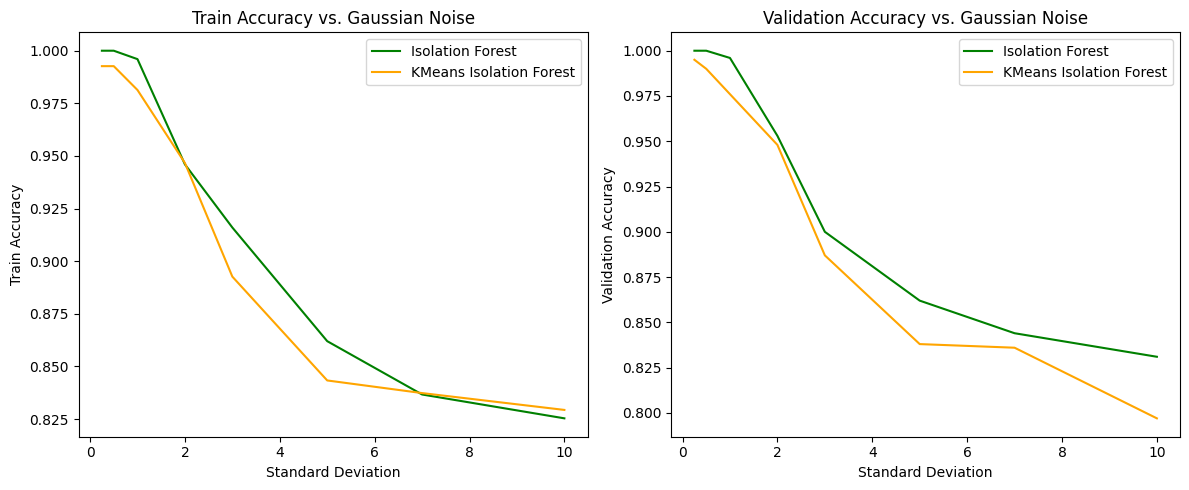

In [83]:
CONTAMINATION = 0.1
ENSEMBLE_SIZE = 100
SUBSAMPLE_SIZE = 128

standard_deviations = [0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0]

isolation_forest_train_accuracies = []
kmeans_isolation_forest_train_accuracies = []

isolation_forest_validation_accuracies = []
kmeans_isolation_forest_validation_accuracies = []

for standard_deviation in standard_deviations:
    Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=1000, n_features=10, contamination=CONTAMINATION, random_state=23)

    Xs_train += np.random.normal(loc=0.0, scale=standard_deviation, size=Xs_train.shape)
    Xs_test += np.random.normal(loc=0.0, scale=standard_deviation, size=Xs_test.shape)

    isolation_forest = IsolationForest(ensemble_size=ENSEMBLE_SIZE)
    kmeans_isolation_forest = KMeansIsolationForest(ensemble_size=ENSEMBLE_SIZE)
    isolation_forest.fit(Xs_train, subsample_size=SUBSAMPLE_SIZE, contamination=CONTAMINATION)
    kmeans_isolation_forest.fit(Xs_train, subsample_size=SUBSAMPLE_SIZE, contamination=CONTAMINATION)

    isolation_forest_train_predictions = isolation_forest.predict(Xs_train)
    kmeans_isolation_forest_train_predictions = kmeans_isolation_forest.predict(Xs_train)
    isolation_forest_validation_predictions = isolation_forest.predict(Xs_test)
    kmeans_isolation_forest_validation_predictions = kmeans_isolation_forest.predict(Xs_test)

    isolation_forest_train_accuracy = np.mean(isolation_forest_train_predictions == Ys_train)
    kmeans_isolation_forest_train_accuracy = np.mean(kmeans_isolation_forest_train_predictions == Ys_train)
    isolation_forest_validation_accuracy = np.mean(isolation_forest_validation_predictions == Ys_test)
    kmeans_isolation_forest_validation_accuracy = np.mean(kmeans_isolation_forest_validation_predictions == Ys_test)

    print(f'Isolation Forest Train Accuracy with standard_deviation={standard_deviation}: {isolation_forest_train_accuracy}')
    print(f'KMeans Isolation Forest Train Accuracy with standard_deviation={standard_deviation}: {kmeans_isolation_forest_train_accuracy}')
    print(f'Isolation Forest Validation Accuracy with standard_deviation={standard_deviation}: {isolation_forest_validation_accuracy}')
    print(f'KMeans Isolation Forest Validation Accuracy with standard_deviation={standard_deviation}: {kmeans_isolation_forest_validation_accuracy}')

    isolation_forest_train_accuracies.append(isolation_forest_train_accuracy)
    kmeans_isolation_forest_train_accuracies.append(kmeans_isolation_forest_train_accuracy)
    isolation_forest_validation_accuracies.append(isolation_forest_validation_accuracy)
    kmeans_isolation_forest_validation_accuracies.append(kmeans_isolation_forest_validation_accuracy)

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()
axes[0].set_title('Train Accuracy vs. Gaussian Noise')
axes[0].set_xlabel('Standard Deviation')
axes[0].set_ylabel('Train Accuracy')
axes[0].plot(standard_deviations, isolation_forest_train_accuracies, label='Isolation Forest', c='green')
axes[0].plot(standard_deviations, kmeans_isolation_forest_train_accuracies, label='KMeans Isolation Forest', c='orange')
axes[0].legend()

axes[1].set_title('Validation Accuracy vs. Gaussian Noise')
axes[1].set_xlabel('Standard Deviation')
axes[1].set_ylabel('Validation Accuracy')
axes[1].plot(standard_deviations, isolation_forest_validation_accuracies, label='Isolation Forest', c='green')
axes[1].plot(standard_deviations, kmeans_isolation_forest_validation_accuracies, label='KMeans Isolation Forest', c='orange')
axes[1].legend()

plt.tight_layout()
plt.show()